In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import hexMinisom
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
import pickle
from sammon import sammon
import itertools
# import igraph as ig
import colorsys
import random
import datetime as dt

In [2]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)
    return som

def generate_distinct_colors(n):
    colors = []
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        colors.append(hex_color)

    random.shuffle(colors)
    return colors

# Get the counts of each WR_label for each node in SOM
def get_WR_counts(l, return_percents=False, indices=None):

    # Take only the data from days with the given indices in indices
    if indices is None:
        labels, counts = np.unique([WR_labels[i] for i in l], return_counts=True)
    else:
        labels, counts = np.unique([WR_labels[i] for i in l if i in indices], return_counts=True)

    # If the node has no days of a given regime add the regime to the labels and 0 as its count
    if len(labels) != len(WR_labels_dict.keys()):
        missing_values = np.setdiff1d(list(WR_labels_dict.keys()), labels)

        labels = WR_labels_dict.keys()

        for v in missing_values:
           counts = np.insert(counts, v, 0)

    # Calculate the percents
    if return_percents:
        counts = 100 * counts / sum(counts)

    regime_counts = dict(zip(labels, counts))
    return regime_counts

# Plotting functions
def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    #maxCount = 553  #frequency
    #maxCount = 4.39   #persistence
    minCount = min(v for v in data.values())
    #minCount = 65    #frequency
    #minCount = 1.23   #persistence
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # Only use non-masked nodes
            if som._mask[i, j] == 0:
                # If theres no data still plot the hexagon
                if (i, j) not in data:
                    data[(i,j)] = 0
                    
                # determine the hexagon position and color
                wy = yy[(j, i)] * np.sqrt(3) / 2
                colorWeight = data[(i, j)]/maxCount
                
                # Create hexagon and add it to axis
                hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                        facecolor=cmap(colorWeight), edgecolor='grey')
                ax.add_patch(hex)
                
                # determine the color the text should be based on color of node
                if colorWeight >= .75:
                    textColor = 'white'
                else:
                    textColor = 'black'
                
                # add text to hexagon for its frequency
                plt.text(xx[(j, i)], wy - .07, f'{data[(i, j)]}', 
                         {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 17})
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(
        norm=norm, cmap=cmap), ax=ax, location='bottom', anchor=(.56, 2.3), shrink=.65, extend='both'
                     )
    cb.set_label(cbLabel, fontsize=17)
    cb.ax.tick_params(labelsize=17)
    
    # Title the plot
    plt.title(title, fontsize=17, y=.95, x=.515)
    return fig

def hex_frequency_plot(som, winmap=None):

    if winmap == None:
        winmap = som.win_map(dataarray)
    
    data = {k: len(v) for k, v in winmap.items()}
    
    fig = hex_heatmap(som, data, 'Blues', '(a) SOM Node Frequencies', 'Count')
    return fig

def hex_plot(som, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # Extract the needed data from the som
    n = som._num
    xy = (2 * n) - 1
    mask = som._mask
    node_indices_xy = np.ma.where(mask == False)
    node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))

    # create figure
    totRows = xy * 3
    totCols = xy * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(xy), range(xy))):

        # make a subplot for the nodes not masked
        if (y, x) in node_indices: # for showing in the proper orientation x and y must be switched
            
            # odd rows will be offset to keep the hexagonal shape
            if y % 2 == 0:
                curRow = x * 3
            else:
                curRow = (x * 3) + 1
                
            curCol = (totCols - 2) - (y * 2)

            ax = plt.subplot2grid(
                (totCols, totRows), (curCol, curRow), rowspan=2, colspan=2, projection=projection
            )
            ax.set_title(node_nums[(y, x)])
            
            if projection is not None:
                ax.set_extent([-180, -30, 20, 80], crs=projection)
        
            axs[(y, x)] = ax
    return fig, axs

def find_longest_consecutive_index(arr):
    if not arr.size:
        return -1  # Handle empty array

    max_len = 0
    start_index = -1
    current_len = 1
    current_start = 0

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            current_len += 1
        else:
            if current_len > max_len:
                max_len = current_len
                start_index = current_start
            current_len = 1
            current_start = i

    # Check if the last sequence is the longest
    if current_len > max_len:
        start_index = current_start
    return start_index

def trend_significance(group, alpha=.05):
    g = list(group)
    slopes = []
    iters = 10000
    
    for i in range(iters):
        samples = []
        for j in range(len(group)):
            samples.extend(random.sample(g, 1))
            
        m = np.polyfit(group.index, samples, 1)[0]
        slopes.append(m)
        
    lower = np.percentile(slopes, (alpha/2) * 100)
    upper = np.percentile(slopes, (1 - alpha/2) * 100)
    return lower, upper

In [3]:
dataset = xr.open_dataarray('/glade/work/molina/DATA/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

# Seasonal breakdown of the data
DJF = dataset.time.dt.month.isin([12, 1, 2])
DJF_idxs = np.array(DJF).nonzero()[0]
MAM = dataset.time.dt.month.isin([3, 4, 5])
MAM_idxs = np.array(MAM).nonzero()[0]
JJA = dataset.time.dt.month.isin([6, 7, 8])
JJA_idxs = np.array(JJA).nonzero()[0]
SON = dataset.time.dt.month.isin([9, 10, 11])
SON_idxs = np.array(SON).nonzero()[0]

print(dataarray.shape)

(30660, 9211)


In [4]:
som = load_som('SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)
# Seasonal breakdown for winmap
DJF_winmap = {}
MAM_winmap = {}
JJA_winmap = {}
SON_winmap = {}

# Loop through each node
for k, v in winmap.items():
    
    # Keep only the days that are in the given season
    DJF_winmap[k] = [i for i in v if i in DJF_idxs]
    MAM_winmap[k] = [i for i in v if i in MAM_idxs]
    JJA_winmap[k] = [i for i in v if i in JJA_idxs]
    SON_winmap[k] = [i for i in v if i in SON_idxs]

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

# Calculate the node number for each coordinate
node_nums = {}
n = 1
for i in range(mask.shape[0])[::-1]:
    for j in range(mask.shape[1]):
        # only use non masked nodes
        if som._mask[i, j] == 0:
            node_nums[(i, j)] = n
            n += 1

color_list = generate_distinct_colors(len(node_indices))

In [5]:
print(som._sigma_decay_function)
print(som._learning_rate_decay_function)
print(som._learning_rate)
print(som.neighborhood)
print(som._activation_distance)

<bound method MiniSom._asymptotic_decay of <hexMinisom.MiniSom object at 0x15126fad7770>>
<bound method MiniSom._asymptotic_decay of <hexMinisom.MiniSom object at 0x15126fad7770>>
0.001
<bound method MiniSom._gaussian of <hexMinisom.MiniSom object at 0x15126fad7770>>
<bound method MiniSom._euclidean_distance of <hexMinisom.MiniSom object at 0x15126fad7770>>


In [6]:
# Import the regime labels
WR_labels_df = pd.read_csv('df_labels_nocorrfilt_ERA5.csv')
WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {
    0: 'Polar High', 1: 'Pacific Trough', 2: 'Pacific Ridge', 
    3: 'Alaskan Ridge', 4: 'Atlantic Ridge', 5: 'No WR'
}
WR_labels = np.array(WR_labels_df['WR'])

WRs_by_node = {k: get_WR_counts(v) for k, v in winmap.items()}
WRs_percents = {k: get_WR_counts(v, return_percents=True) for k, v in winmap.items()}

print(WR_labels_df)

# Calculate the 90th percentile of the distances and only keep data less than that
percentile90 = np.percentile(WR_labels_df['distances'], 90)
lt90 = (np.array(WR_labels_df['distances']) < percentile90).nonzero()[0]
WRs_lt90 = {k: get_WR_counts(v, True, lt90) for k, v in winmap.items()}

# Calculate the variances of the distances for each WR
WR_indices = {i: (WR_labels == i).nonzero()[0] for i in np.unique(WR_labels)}
for WR, idxs in WR_indices.items():
    variance = np.var(WR_labels_df['distances'].iloc[idxs])
    
# Get the WR counts for each specific season
WRs_DJF = {k: get_WR_counts(v, True, DJF_idxs) for k, v in winmap.items()}
WRs_MAM = {k: get_WR_counts(v, True, MAM_idxs) for k, v in winmap.items()}
WRs_JJA = {k: get_WR_counts(v, True, JJA_idxs) for k, v in winmap.items()}
WRs_SON = {k: get_WR_counts(v, True, SON_idxs) for k, v in winmap.items()}

            date  WR  distances      corr
0     1940-01-01   0   2.463938  0.518457
1     1940-01-02   0   2.662645  0.565398
2     1940-01-03   0   2.916932  0.552532
3     1940-01-04   0   3.122750  0.495652
4     1940-01-05   0   3.302769  0.394692
...          ...  ..        ...       ...
30655 2023-12-27   1   2.823370  0.857459
30656 2023-12-28   1   2.687266  0.837698
30657 2023-12-29   1   2.394127  0.781903
30658 2023-12-30   1   2.253624  0.655454
30659 2023-12-31   0   2.468174  0.359541

[30660 rows x 4 columns]


In [7]:
num_years = 20

# subset our wr labels data
old_wr_labels = WR_labels_df[WR_labels_df['date'].dt.year < WR_labels_df['date'][0].year + num_years]['WR']
new_wr_labels = WR_labels_df[WR_labels_df['date'].dt.year > WR_labels_df['date'].iloc[-1].year - num_years]['WR']

# Get the winning nodes for just our timeframes
old_idxs = list(old_wr_labels.index)
new_idxs = list(new_wr_labels.index)

# calculate the WR percents for each node
#old_wr_percents = {k: get_WR_counts(v, return_percents=True, indices=old_idxs) for k, v in winmap.items()}
#new_wr_percents = {k: get_WR_counts(v, return_percents=True, indices=new_idxs) for k, v in winmap.items()}

old_wr_counts = {k: get_WR_counts(v, indices=old_idxs) for k, v in winmap.items()}
new_wr_counts = {k: get_WR_counts(v, indices=new_idxs) for k, v in winmap.items()}

# Calculate the min and max for axis scaling 
min_diff_percent = 100
max_diff_percent = -100

diff_percent = {}
for node in winmap.keys():
    diff = {}
    
    for WR in [0,1,2,3,4,5]:
        #difference = new_wr_percents[node][WR] - old_wr_percents[node][WR]
        
        # percent change
        if old_wr_counts[node][WR] == 0:
            percent = 0
        else:
            percent = 100 * (new_wr_counts[node][WR] - old_wr_counts[node][WR]) / old_wr_counts[node][WR]
        
        diff[WR] = percent
        
        if percent > max_diff_percent:
            max_diff_percent = percent
            
        if percent < min_diff_percent:
            min_diff_percent = percent
    
    diff_percent[node] = diff

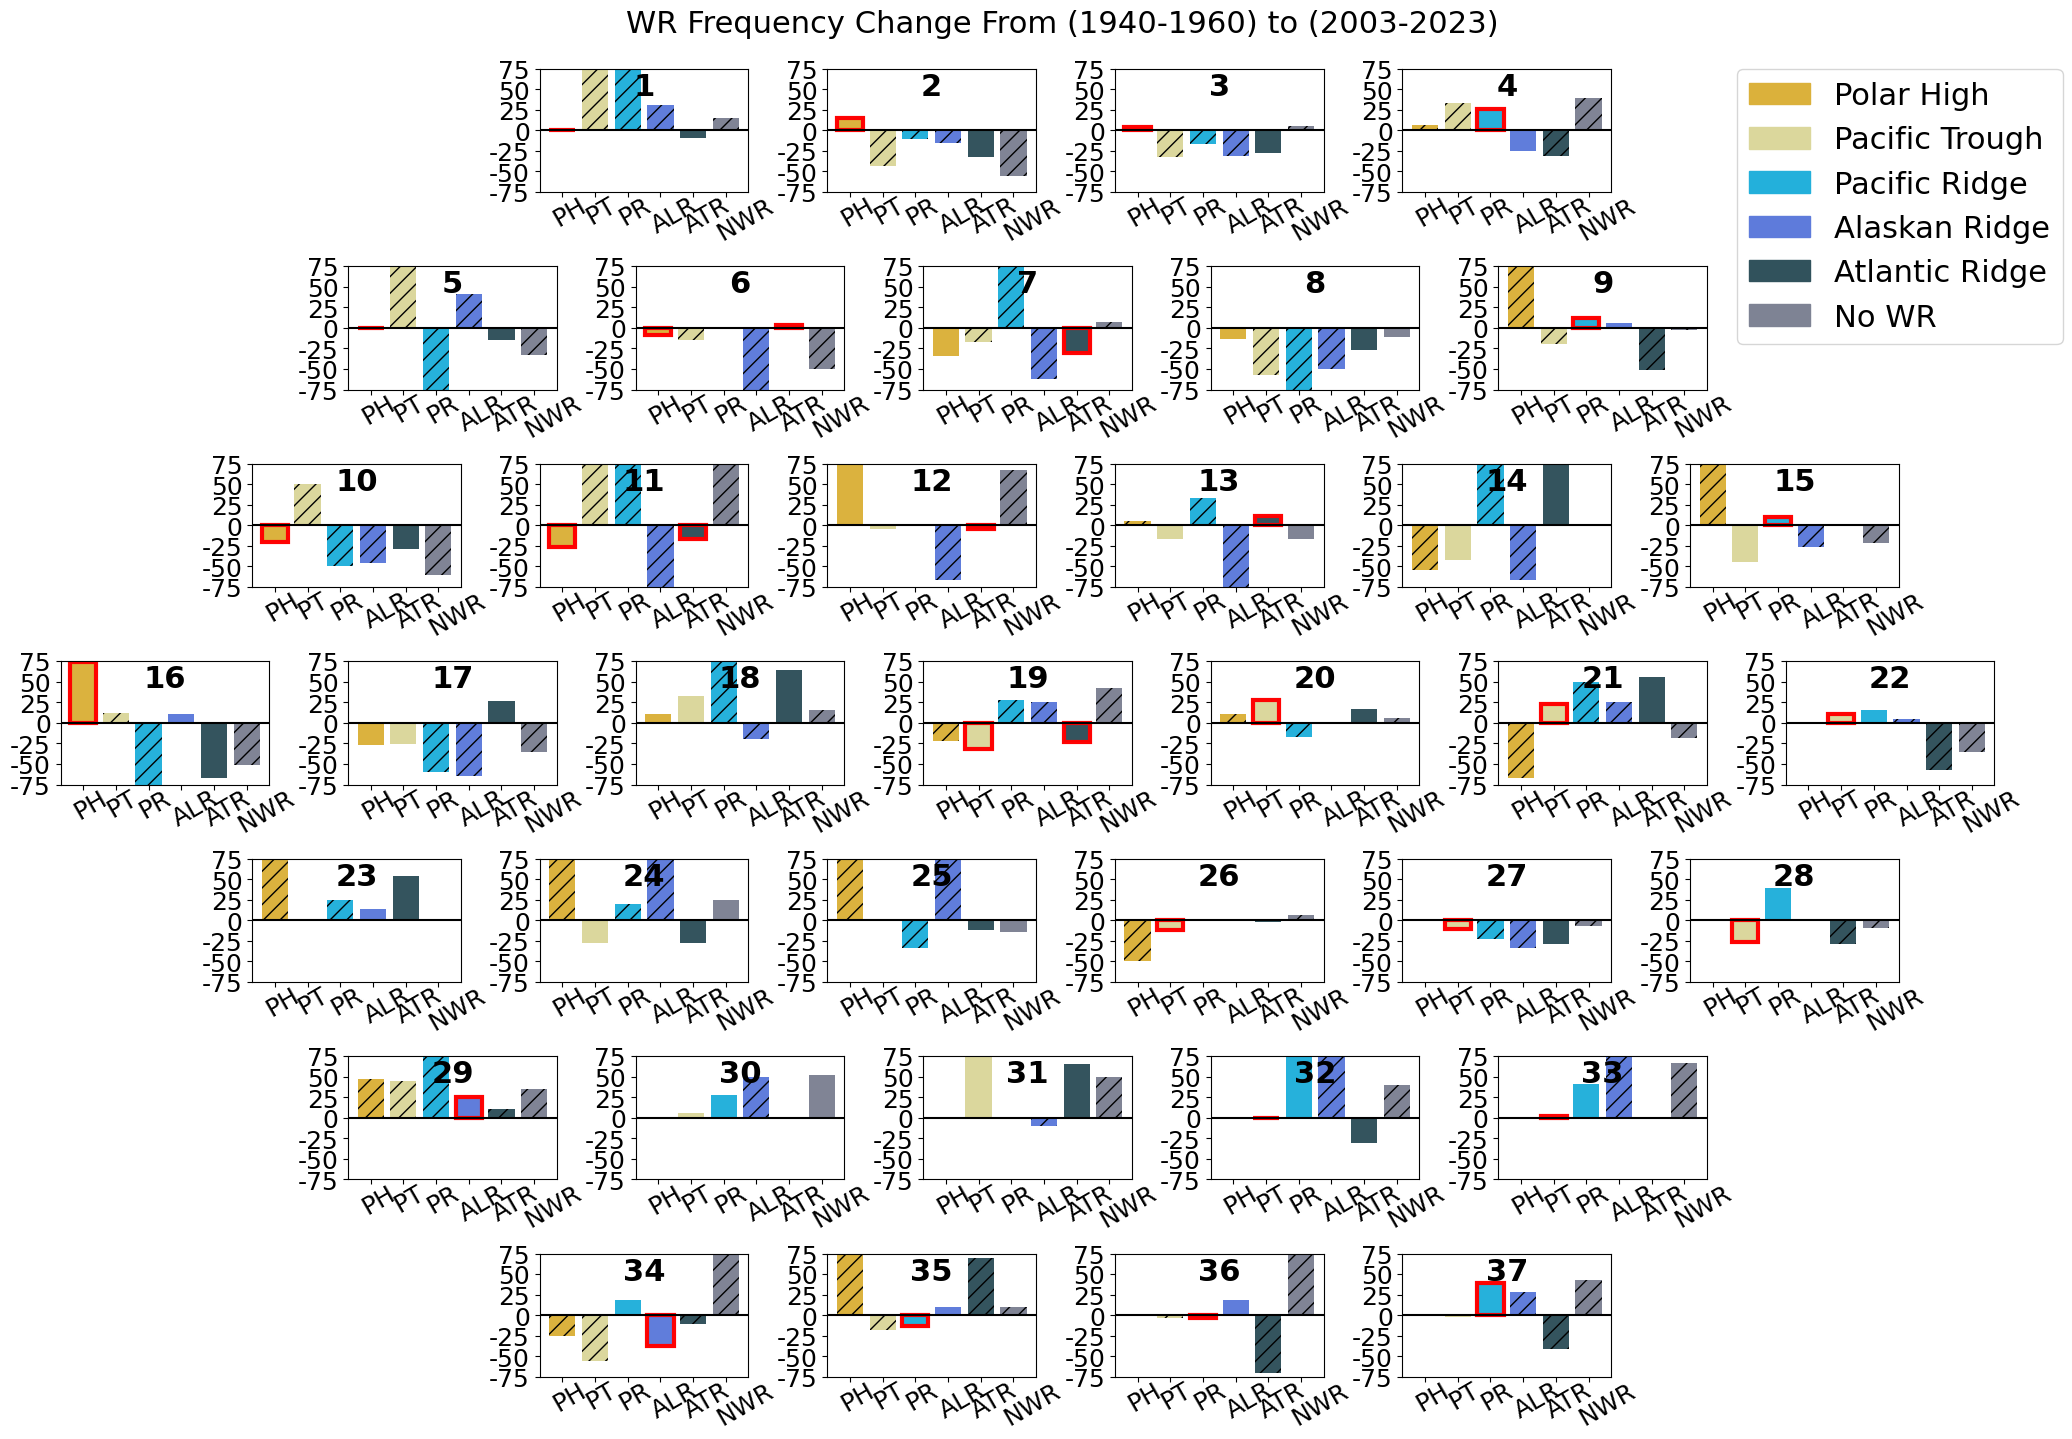

In [8]:
fig, axs = hex_plot(som)
fs= 22

for node in node_indices:
    ax = axs[node[0], node[1]]

    categories = WR_labels_dict.values()
    categories = [0, 1, 2, 3, 4, 5]
    values = diff_percent[node].values()
    wr_colors = ['#DBB13B', '#DBD79C', '#23B0DB', '#5E7BDB', '#31525C', '#7E8394']

    bars = ax.bar(categories, values, color=wr_colors, alpha=.99)
    ax.hlines(0, 0, 1, transform=ax.get_yaxis_transform(), color='k')
    #ax.get_xaxis().set_visible(False)
    # Hide axis labels
    ax.set_xticks(categories)
    ax.xaxis.set_ticklabels([])
    #ax.spines['bottom'].set_visible(False)
    
    ax.set_ylim(ymin=-75, ymax=75)
    yticks = [-75, -50, -25, 0, 25, 50, 75]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontdict={'fontsize': fs - 4})
    
    labels = ["PH", "PT", "PR", "ALR", "ATR", "NWR"]
    xlocations = [bar.xy[0] for bar in bars]

    for i, xloc in enumerate(xlocations):
        ax.text(xloc, -76, labels[i], va='top', ha='left', 
                fontdict={'fontsize': fs - 4, 'rotation':30})
    
    # Put a boarder around bars for the diminating regimes
    # Determine if there is a dominating regime
    k, v = zip(*WRs_by_node[(node[0], node[1])].items())
    dominating_regime = (np.nonzero(v > np.sum(v) * (1/3)))[0]
    hatched_regime = (np.nonzero(v < np.sum(v) * (1/6)))[0]
    
    for regime in dominating_regime:
        bars[regime].set_edgecolor('red')
        bars[regime].set_linewidth(3)
        
    for regime in hatched_regime:
        bars[regime].set_hatch('//')
        bars[regime].set_facecolor(wr_colors[regime])
    
    # Remove spines
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    
    ax.set_title(node_nums[node], fontdict={'fontweight': 'bold', 'fontsize': fs}, y=.72)

plt.tight_layout()

# Create the legend
WR_patches = []
for WR in WR_labels_dict.keys():
    WR_patches.append(patches.Patch(color=wr_colors[WR], label=WR_labels_dict[WR]))
    
plt.legend(handles=WR_patches, bbox_to_anchor=(.15, 4.32), fontsize=fs)
plt.suptitle('WR Frequency Change From (1940-1960) to (2003-2023)', y=1.025, x=.53, fontsize=fs)
plt.subplots_adjust(wspace=-0.15, hspace=3)

plt.savefig('WR_trends_bars.pdf', transparent=True, bbox_inches='tight')
#plt.show()